In [5]:
# libraries
import pandas as pd
import numpy as np
import tensorflow as tf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Corr.
Number of features selected: 23
train R2 : 0.745
test R2 : 0.546
Lasso


KeyboardInterrupt: 

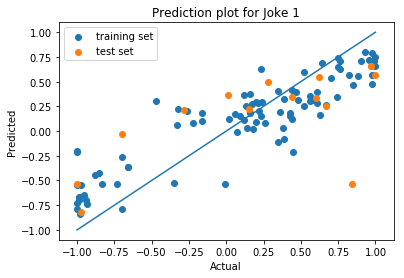

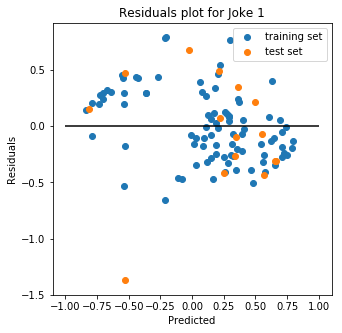

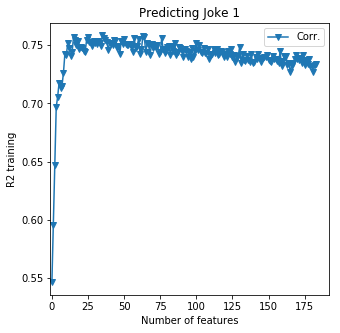

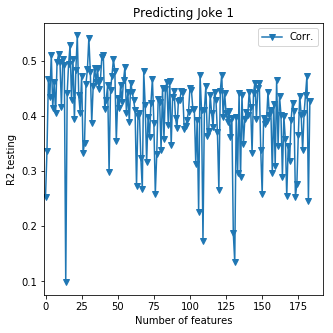

In [17]:
# original
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 25 21:16:14 2018

@author: T
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor 

#X = data.drop(['joke1'], axis = 1)
#y = data['joke1']
#first few variables of the first few principal components
#princomp = pd.DataFrame(pca.components_.T).iloc[:65,:1]
#top 10 features of first principal component
#pcafeatures = []
#for item in princomp.sort_values(by=[0], ascending=False).index.tolist()[:10]:
#    pcafeatures.append(X.columns[item])

def PCR(regr, labeling):
    pca = PCA()
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=100)
    
    X_reduced_train = pca.fit_transform(train_X)
    n = len(X_reduced_train)
    kf_10 = model_selection.KFold(n, n_folds=10, shuffle=True, random_state=1)
    r2 = []
    score = -1*cross_val_score(regr, np.ones((n,1)), train_y.ravel(), cv=kf_10, scoring='r2').mean()
    r2.append(score)
    
    for i in np.arange(1, 20):
        score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], train_y.ravel(), cv=kf_10, scoring='r2').mean()
        r2.append(score)
    
    plt.plot(r2, '-v', label=labeling)
    plt.xlabel('Number of principal components in regression')
    plt.ylabel('R2')
    plt.title('Predicting Joke 1')
    plt.xlim(xmin=-1);
    plt.legend()
    
    np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    numcomp = r2.index(max(r2))
    print("Number of principal components: {}" .format(numcomp))
    
    X_reduced_test = pca.transform(test_X)[:,:numcomp+1]
    X_reduced_train = pca.transform(train_X)[:,:numcomp+1]
    regr.fit(X_reduced_train[:,:numcomp+1], train_y)
    pred_train = regr.predict(X_reduced_train)
    pred_test = regr.predict(X_reduced_test)
    print("{} train R2 : {:.3f}" .format(labeling, r2_score(train_y, pred_train)))
    print("{} test R2 : {:.3f}" .format(labeling, r2_score(test_y, pred_test)))
#    print("MSE: {:.3f}".format(mean_squared_error(test_y, pred)))
#    print('train R2 : {:.3f}'.format(regr.score(train_y, pred_train)))

def r2(pred, actual):
    RSS = 0
    TSS = 0
    for i in range(0, len(pred)):
        TSS = TSS + ((actual[i] - np.mean(actual))**2)
        RSS = RSS + ((actual[i] - pred[i])**2)
    R2 = 1-RSS/TSS
    return R2

def mse(y, y_pred):
    return np.mean((y-y_pred)**2)

def evaluation(regr, labeling, ranked_features):
    totaltrainr2 = []
    totaltestr2 = []
    totaltrainmse = []
    totaltestmse = []
    min_test_mse = 0
    max_test_r2 = 0
    num_features_to_use = 0
    
    #iterating over the ranked features from most to least important
    for i in range(1,len(ranked_features)):
        trainr2 = []
        testr2 = []
        mse_train = []
        mse_test = []
        test_features = ranked_features[:i]
        n = len(X[test_features])

        from sklearn.model_selection import KFold 
        kf = KFold(n_splits=7, shuffle=True) 
        
        for train_index, test_index in kf.split(X[test_features]):
              train_X, test_X = X[test_features].iloc[train_index], X[test_features].iloc[test_index] 
              train_y, test_y = y.iloc[train_index], y.iloc[test_index]     
             
              regr.fit(train_X, train_y)
              pred_train = regr.predict(train_X)
              pred_test = regr.predict(test_X)
              
              trainr2.append(r2(pred_train,list(train_y)))
              testr2.append(r2(pred_test, list(test_y)))              
              
              mse_train.append(mse(train_y, list(pred_train)))              
              mse_test.append(mse(test_y, list(pred_test)))   
          
        totaltrainr2.append(np.mean(trainr2))
        totaltestr2.append(np.mean(testr2))
        totaltrainmse.append(np.mean(mse_train))
        totaltestmse.append(np.mean(mse_test))
        
#        if min_test_mse == 0:
#            min_test_mse = np.mean(mse_test)
        if max_test_r2 == 0:
            max_test_r2 = np.mean(testr2)
#        if np.mean(mse_test) < min_test_mse:
        if np.mean(testr2) > max_test_r2:
#            min_test_mse = np.mean(mse_test)
#            min_train_mse = np.mean(mse_train)
            max_test_r2 = np.mean(testr2)
            max_train_r2 = np.mean(trainr2)
            num_of_features_to_use = i
            used_train_y = train_y
            used_pred_train = pred_train
            used_test_y = test_y
            used_pred_test = pred_test
            
    print("Number of features selected: {}".format(num_of_features_to_use))
    print("train R2 : {:.3f}" .format(max_train_r2))
    print("test R2 : {:.3f}" .format(max_test_r2))    
#    print("train MSE: {:.3f}".format(min_train_mse))
#    print("test MSE: {:.3f}".format(min_test_mse))
    
    #pred v. actual & residual plots        
    plt.scatter(used_train_y, used_pred_train, label='training set')
    plt.scatter(used_test_y, used_pred_test, label='test set')
    plt.plot( [-1,1],[-1,1] )
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Prediction plot for Joke 1')        
    plt.legend()
    plt.figure(figsize=(5,5))    

    plt.scatter(used_pred_train, used_pred_train-used_train_y, label='training set')
    plt.scatter(used_pred_test, used_pred_test-used_test_y, label='test set')
    plt.hlines(y=0, xmin=-1, xmax=1)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals plot for Joke 1')
    plt.legend()
    plt.figure(figsize=(5,5))    

    #Training plots
#    plt.plot(totaltrainmse, '-v', label=labeling)
#    plt.xlabel('Number of features')
#    plt.ylabel('MSE training')
#    plt.title('Predicting Joke 1')
#    plt.xlim(xmin=-1);
#    plt.legend()
#    plt.figure(figsize=(5,5))

    plt.plot(totaltrainr2, '-v', label=labeling)
    plt.xlabel('Number of features')
    plt.ylabel('R2 training')
    plt.title('Predicting Joke 1')
    plt.xlim(xmin=-1);
    plt.legend()
    plt.figure(figsize=(5,5))

    #Testing plots
#    plt.plot(totaltestmse, '-v', label=labeling)
#    plt.xlabel('Number of features')
#    plt.ylabel('MSE testing')
#    plt.title('Predicting Joke 1')
#    plt.xlim(xmin=-1);
#    plt.legend()
#    plt.figure(figsize=(5,5))    
    
    plt.plot(totaltestr2, '-v', label=labeling)
    plt.xlabel('Number of features')
    plt.ylabel('R2 testing')
    plt.title('Predicting Joke 1')
    plt.xlim(xmin=-1);
    plt.legend()
    plt.figure(figsize=(5,5))    
    
    
def rank_to_dict(ranks, names, order=1):
    from sklearn.preprocessing import MinMaxScaler
    
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

def list_features(key, features, names):
    featurelist = []
    for i in features.sort_values(key, ascending = False).index.values:
        featurelist.append(names[i])
    return(featurelist)         

def feature_selection():
    from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
    from sklearn.feature_selection import RFE, f_regression
     
    np.random.seed(0)
    names = X.columns
    ranks = {}

    lr = LinearRegression(fit_intercept=True,normalize=False)         
    lr.fit(X, y)
    ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)
     
    ridge = Ridge(alpha=7)
    ridge.fit(X, y)
    ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)
     
    lasso = Lasso(alpha=.05)
    lasso.fit(X, y)
    ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)
      
    ##stop the search when 5 features are left (they will get equal scores)
    regr = RandomForestRegressor(n_estimators=50, max_features="sqrt", min_samples_leaf=4, max_depth=3, bootstrap=True)
    rfe = RFE(regr, n_features_to_select=5)
    rfe.fit(X,y)
    ranks["RFE"] = rank_to_dict(list(map(float,rfe.ranking_)), names, order=-1)
     
    rf = RandomForestRegressor(n_estimators=50, max_features="sqrt", min_samples_leaf=4, max_depth=3, bootstrap=True)
    rf.fit(X,y)
    ranks["RF"] = rank_to_dict(rf.feature_importances_, names)
     
    f, pval  = f_regression(X, y, center=True)
    ranks["Corr."] = rank_to_dict(f, names)
     
    r = {}
    for name in names:
        r[name] = round(np.mean([ranks[method][name] 
                                 for method in ranks.keys()]), 2)
    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")
    
    #extract features in order of most to least important
    matrix = []
    matrix.append(methods)
    for name in names:
        matrix.append(list(map(str,[ranks[method][name] for method in methods])))
    npmat = np.array(matrix)
    ranked_features = pd.DataFrame(data=npmat[1:,0:], columns=npmat[0,0:])

    #just testing random forest for now
    models = [RandomForestRegressor(n_estimators=50, max_features="sqrt", min_samples_leaf=4, max_depth=3, bootstrap=True)] #SVR(kernel="sigmoid", C=0.5, coef0=-0.5)] #MLPRegressor(hidden_layer_sizes = (3),max_iter=500)]    
    for model in models: 
        print(model)
        for feature_selection_method in methods:
            print(feature_selection_method)
#        feature_selection_method = "RFE" #Just testing RFE for now    
            evaluation(model, feature_selection_method, list_features(feature_selection_method,ranked_features,names))

    
def LOF(): #Removing outliers
    from sklearn.neighbors import LocalOutlierFactor
    
    clf = LocalOutlierFactor(n_neighbors=20)
    y_pred = clf.fit_predict(data)
    outliers = [i for i, x in enumerate(y_pred.tolist()) if x == -1]
    print(outliers)
    print(data)
    data.drop(outliers, inplace=True)
    data.reset_index(drop=True, inplace=True)
    data.to_csv("dataoutlier.csv")
    

data = pd.read_csv('data-LOFapplied.csv')
#LOF()
jokes = list(data.columns)[list(data.columns).index('joke1'):len(data.columns)]
X = data.drop(jokes[75], axis=1)
y = data[jokes[75]]
feature_selection()

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 25 21:16:14 2018

@author: T
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor 

#X = data.drop(['joke1'], axis = 1)
#y = data['joke1']
#first few variables of the first few principal components
#princomp = pd.DataFrame(pca.components_.T).iloc[:65,:1]
#top 10 features of first principal component
#pcafeatures = []
#for item in princomp.sort_values(by=[0], ascending=False).index.tolist()[:10]:
#    pcafeatures.append(X.columns[item])

def PCR(regr, labeling):
    pca = PCA()
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=100)
    
    X_reduced_train = pca.fit_transform(train_X)
    n = len(X_reduced_train)
    kf_10 = model_selection.KFold(n, n_folds=10, shuffle=True, random_state=1)
    r2 = []
    score = -1*cross_val_score(regr, np.ones((n,1)), train_y.ravel(), cv=kf_10, scoring='r2').mean()
    r2.append(score)
    
    for i in np.arange(1, 20):
        score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], train_y.ravel(), cv=kf_10, scoring='r2').mean()
        r2.append(score)
    
    plt.plot(r2, '-v', label=labeling)
    plt.xlabel('Number of principal components in regression')
    plt.ylabel('R2')
    plt.title('Predicting Joke 1')
    plt.xlim(xmin=-1);
    plt.legend()
    
    np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    numcomp = r2.index(max(r2))
    print("Number of principal components: {}" .format(numcomp))
    
    X_reduced_test = pca.transform(test_X)[:,:numcomp+1]
    X_reduced_train = pca.transform(train_X)[:,:numcomp+1]
    regr.fit(X_reduced_train[:,:numcomp+1], train_y)
    pred_train = regr.predict(X_reduced_train)
    pred_test = regr.predict(X_reduced_test)
    print("{} train R2 : {:.3f}" .format(labeling, r2_score(train_y, pred_train)))
    print("{} test R2 : {:.3f}" .format(labeling, r2_score(test_y, pred_test)))
#    print("MSE: {:.3f}".format(mean_squared_error(test_y, pred)))
#    print('train R2 : {:.3f}'.format(regr.score(train_y, pred_train)))

def r2(pred, actual):
    RSS = 0
    TSS = 0
    for i in range(0, len(pred)):
        TSS = TSS + ((actual[i] - np.mean(actual))**2)
        RSS = RSS + ((actual[i] - pred[i])**2)
    R2 = 1-RSS/TSS
    return R2

def mse(y, y_pred):
    return np.mean((y-y_pred)**2)

def evaluation(regr, labeling, ranked_features):
    totaltrainr2 = []
    totaltestr2 = []
    totaltrainmse = []
    totaltestmse = []
    min_test_mse = 0
    max_test_r2 = 0
    num_features_to_use = 0
    
    #iterating over the ranked features from most to least important
    for i in range(1,len(ranked_features)):
        trainr2 = []
        testr2 = []
        mse_train = []
        mse_test = []
        test_features = ranked_features[:i]
        n = len(X[test_features])

        from sklearn.model_selection import KFold 
        kf = KFold(n_splits=7, shuffle=True) 
        
        for train_index, test_index in kf.split(X[test_features]):
              train_X, test_X = X[test_features].iloc[train_index], X[test_features].iloc[test_index] 
              train_y, test_y = y.iloc[train_index], y.iloc[test_index]     
             
              regr.fit(train_X, train_y)
              pred_train = regr.predict(train_X)
              pred_test = regr.predict(test_X)
              
              trainr2.append(r2(pred_train,list(train_y)))
              testr2.append(r2(pred_test, list(test_y)))              
              
              mse_train.append(mse(train_y, list(pred_train)))              
              mse_test.append(mse(test_y, list(pred_test)))   
          
        totaltrainr2.append(np.mean(trainr2))
        totaltestr2.append(np.mean(testr2))
        totaltrainmse.append(np.mean(mse_train))
        totaltestmse.append(np.mean(mse_test))
        
#        if min_test_mse == 0:
#            min_test_mse = np.mean(mse_test)
        if max_test_r2 == 0:
            max_test_r2 = np.mean(testr2)
#        if np.mean(mse_test) < min_test_mse:
        if np.mean(testr2) > max_test_r2:
#            min_test_mse = np.mean(mse_test)
#            min_train_mse = np.mean(mse_train)
            max_test_r2 = np.mean(testr2)
            max_train_r2 = np.mean(trainr2)
            num_of_features_to_use = i
            used_train_y = train_y
            used_pred_train = pred_train
            used_test_y = test_y
            used_pred_test = pred_test
            
    print("Number of features selected: {}".format(num_of_features_to_use))
    print("train R2 : {:.3f}" .format(max_train_r2))
    print("test R2 : {:.3f}" .format(max_test_r2))    
#    print("train MSE: {:.3f}".format(min_train_mse))
#    print("test MSE: {:.3f}".format(min_test_mse))
    
    #pred v. actual & residual plots        
    plt.scatter(used_train_y, used_pred_train, label='training set')
    plt.scatter(used_test_y, used_pred_test, label='test set')
    plt.plot( [-1,1],[-1,1] )
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Prediction plot for Joke 1')        
    plt.legend()
    plt.figure(figsize=(5,5))    

    plt.scatter(used_pred_train, used_pred_train-used_train_y, label='training set')
    plt.scatter(used_pred_test, used_pred_test-used_test_y, label='test set')
    plt.hlines(y=0, xmin=-1, xmax=1)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals plot for Joke 1')
    plt.legend()
    plt.figure(figsize=(5,5))    

    #Training plots
#    plt.plot(totaltrainmse, '-v', label=labeling)
#    plt.xlabel('Number of features')
#    plt.ylabel('MSE training')
#    plt.title('Predicting Joke 1')
#    plt.xlim(xmin=-1);
#    plt.legend()
#    plt.figure(figsize=(5,5))

    plt.plot(totaltrainr2, '-v', label=labeling)
    plt.xlabel('Number of features')
    plt.ylabel('R2 training')
    plt.title('Predicting Joke 1')
    plt.xlim(xmin=-1);
    plt.legend()
    plt.figure(figsize=(5,5))

    #Testing plots
#    plt.plot(totaltestmse, '-v', label=labeling)
#    plt.xlabel('Number of features')
#    plt.ylabel('MSE testing')
#    plt.title('Predicting Joke 1')
#    plt.xlim(xmin=-1);
#    plt.legend()
#    plt.figure(figsize=(5,5))    
    
    plt.plot(totaltestr2, '-v', label=labeling)
    plt.xlabel('Number of features')
    plt.ylabel('R2 testing')
    plt.title('Predicting Joke 1')
    plt.xlim(xmin=-1);
    plt.legend()
    plt.figure(figsize=(5,5))    
    
    
def rank_to_dict(ranks, names, order=1):
    from sklearn.preprocessing import MinMaxScaler
    
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

def list_features(key, features, names):
    featurelist = []
    for i in features.sort_values(key, ascending = False).index.values:
        featurelist.append(names[i])
    return(featurelist)         

def feature_selection():
    from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
    from sklearn.feature_selection import RFE, f_regression
     
    np.random.seed(0)
    names = X.columns
    ranks = {}

    lr = LinearRegression(fit_intercept=True,normalize=False)         
    lr.fit(X, y)
    ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)

     
    ridge = Ridge(alpha=7)
    ridge.fit(X, y)
    ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)
    lasso = Lasso(alpha=.05)
    lasso.fit(X, y)
    ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)
    print lasso.coef_
    ##stop the search when 5 features are left (they will get equal scores)
    regr = RandomForestRegressor(n_estimators=50, max_features="sqrt", min_samples_leaf=4, max_depth=3, bootstrap=True)
    rfe = RFE(regr, n_features_to_select=5)
    rfe.fit(X,y)
    ranks["RFE"] = rank_to_dict(list(map(float,rfe.ranking_)), names, order=-1)
     
    rf = RandomForestRegressor(n_estimators=50, max_features="sqrt", min_samples_leaf=4, max_depth=3, bootstrap=True)
    rf.fit(X,y)
    ranks["RF"] = rank_to_dict(rf.feature_importances_, names)
     
    f, pval  = f_regression(X, y, center=True)
    ranks["Corr."] = rank_to_dict(f, names)
     
    r = {}
    for name in names:
        r[name] = round(np.mean([ranks[method][name] 
                                 for method in ranks.keys()]), 2)
    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")
    
    #extract features in order of most to least important
    matrix = []
    matrix.append(methods)
    for name in names:
        matrix.append(list(map(str,[ranks[method][name] for method in methods])))
    npmat = np.array(matrix)
    ranked_features = pd.DataFrame(data=npmat[1:,0:], columns=npmat[0,0:])

    #just testing random forest for now
    models = [RandomForestRegressor(n_estimators=50, max_features="sqrt", min_samples_leaf=4, max_depth=3, bootstrap=True)] #SVR(kernel="sigmoid", C=0.5, coef0=-0.5)] #MLPRegressor(hidden_layer_sizes = (3),max_iter=500)]    
    for model in models: 
        print(model)
        for feature_selection_method in methods:
            print(feature_selection_method)
#        feature_selection_method = "RFE" #Just testing RFE for now    
            evaluation(model, feature_selection_method, list_features(feature_selection_method,ranked_features,names))

    
def LOF(): #Removing outliers
    from sklearn.neighbors import LocalOutlierFactor
    
    clf = LocalOutlierFactor(n_neighbors=20)
    y_pred = clf.fit_predict(data)
    outliers = [i for i, x in enumerate(y_pred.tolist()) if x == -1]
    print(outliers)
    print(data)
    data.drop(outliers, inplace=True)
    data.reset_index(drop=True, inplace=True)
    data.to_csv("dataoutlier.csv")
    

data = pd.read_csv('data-LOFapplied.csv')
#LOF()
jokes = list(data.columns)[list(data.columns).index('joke1'):len(data.columns)]
X = data.drop(jokes[75], axis=1)
y = data[jokes[75]]
feature_selection()

In [6]:
data = pd.read_csv('data-LOFapplied.csv')
#LOF()
jokes = list(data.columns)[list(data.columns).index('joke1'):len(data.columns)]
X = data.drop(jokes[75], axis=1)
y = data[jokes[75]]

In [21]:
X = data.drop(jokes[75], axis=1)
y = data[jokes[75]]

def linear_regression(X, y):
    # Gradient Descent
    rows = X.shape[0]
    n_dim = X.shape[1]

    tf_X = tf.placeholder(tf.float32, [n_dim])
    tf_y = tf.placeholder(tf.float32)

    # set random weight
    W = tf.Variable([np.random.randn() for i in range(n_dim)], name="weight")
    b = tf.Variable(np.random.randn(), name="bias")
    learning_rate = 0.01
    epochs = 100

    # Construct a linear model
    mult = tf.reduce_sum(tf.multiply(tf_X, W))
    pred = tf.add(mult, b)
    cost = tf.reduce_sum(tf.pow(pred-tf_y, 2))/(2.0*rows)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()

    # start training
    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(epochs):
            for i in range(rows):
                _x = X.iloc[i]
                _y = y[i]

                sess.run(optimizer, feed_dict={tf_X: _x, tf_y: _y})
        
        print ("Optimization Finished")
        return sess.run(W)

names = X.columns
ranks = {}
ranks["Linear reg"] = rank_to_dict(np.abs(linear_regression(X, y)), names)
#     print "W=", sess.run(W), "b=", sess.run(b)

Optimization Finished


In [51]:
def lasso_regression(X, y, alpha=1.0):
    #(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1
    rows = X.shape[0]
    n_dim = X.shape[1]

    tf_X = tf.placeholder(tf.float32, [n_dim])
    tf_y = tf.placeholder(tf.float32)
    
    # set random weight
    W = tf.Variable([1.0 for i in range(n_dim)], name="weight")
    b = tf.Variable([1.0], name="bias")
    learning_rate = 0.01
    epochs = 2000
    
    residual = tf_y - tf.reduce_sum(tf.multiply(W, tf_X)) - b
    adding_term = alpha * tf.reduce_sum(tf.abs(W))
    rss = tf.reduce_mean(tf.square(residual)) / 2.
    cost = rss + adding_term
    p = tf.Print(cost, [residual, rss, adding_term], "cost: ", summarize = 200) * 1.
#     cost = tf.reduce_sum(tf.square(predict-y_))/(2.*n_samples) + \
#                     self.alpha*tf.reduce_sum(tf.abs(coeffs))

    # Define the linear model
#     pred = tf.add(tf.reduce_sum(tf.multiply(tf_X, W)), b)

#     # Mean squared error
#     cost = tf.reduce_sum(tf.pow(pred-tf_y, 2))/(2*n_samples)
#     cost = tf.add(cost, tf.multiply(alpha, tf.reduce_sum(tf.abs(W))))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(p)
    init = tf.global_variables_initializer()
    
    display_step = 50
    # start training
    with tf.Session() as sess:
        sess.run(init)
 
        for epoch in range(epochs):
#             c = sess.run(optimizer, feed_dict={tf_X: X, tf_y: y})
            
            if (epoch+1) % display_step == 0:
                for i in range(rows):
                    _x = X.iloc[i]
                    _y = y[i]
                    c = sess.run(cost, feed_dict={tf_X: _x, tf_y: _y})
                print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                    "W=", sess.run(W), "b=", sess.run(b))
            
#         print "Optimization Finished"
        plt.plot(X, y, 'ro', label='Original data')
        plt.plot(X, sess.run(W) * X + sess.run(b), label='Fitted line')
        plt.legend()
        plt.show()
        return sess.run(W)
    
lasso_regression(X, y, 0.05)

Epoch: 0050 cost= 2095.541992188 W= [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.] b= [ 1.]
Epoch: 0100 cost= 2095.541992188 W= [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1. 

Epoch: 0600 cost= 2095.541992188 W= [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.] b= [ 1.]
Epoch: 0650 cost= 2095.541992188 W= [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1. 

KeyboardInterrupt: 

In [ ]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Parameters
learning_rate = 0.01
training_epochs = 1000
display_step = 50

# Generate the training data
train_X = np.linspace(-1, 1, 200)
train_Y = 2*train_X + np.random.randn(*train_X.shape)*0.2
random = [- 3 - np.random.randn() for num in train_Y]
train_Y = train_Y - random

n_samples = train_X.shape[0]

_X = data.drop(jokes[75], axis=1)
_Y = data[jokes[75]]

n_dim = _X.shape[1]
rows = _X.shape[0]

# tf Graph Input
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Initialize the variable w and b
W = tf.Variable(np.random.randn(), name="weight")
b = tf.Variable(np.random.randn(), name="bias")

# Define the linear model
pred = tf.add(tf.multiply(X, W), b)

# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples)
cost = tf.add(cost, tf.multiply(1e-6, tf.global_norm([W])))
 
# LASSO and Ridge Regression
# 
# This function shows how to use TensorFlow to solve LASSO or 
# Ridge regression for 
# y = Ax + b
# 
# We will use the iris data, specifically: 
#   y = Sepal Length 
#   x = Petal Width

# import required libraries
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops


# Specify 'Ridge' or 'LASSO'
#regression_type = 'LASSO'
regression_type = 'LASSO'

# clear out old graph
ops.reset_default_graph()

# Create graph
sess = tf.Session()

###
# Load iris data
###

# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([x[3] for x in iris.data])
y_vals = np.array([y[0] for y in iris.data])

###
# Model Parameters
###

# Declare batch size
batch_size = 50

# Initialize placeholders
x_data = tf.placeholder(shape=[n_dim], dtype=tf.float32)
y_target = tf.placeholder(dtype=tf.float32)

# make results reproducible
# seed = 13
# np.random.seed(seed)
# tf.set_random_seed(seed)

# Create variables for linear regression
A = tf.Variable(tf.random_normal(shape=[n_dim]))
b = tf.Variable(tf.random_normal(shape=[1]))

# Declare model operations
model_output = tf.add(tf.reduce_sum(tf.multiply(x_data, A)), b)

###
# Loss Functions
###

# Select appropriate loss function based on regression type

if regression_type == 'LASSO':
    # Declare Lasso loss function
    # Lasso Loss = L2_Loss + heavyside_step,
    # Where heavyside_step ~ 0 if A < constant, otherwise ~ 99
    lasso_param = tf.constant(0.9)
    heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-50., tf.subtract(A, lasso_param)))))
    regularization_param = tf.multiply(heavyside_step, 99.)
    loss = tf.add(tf.reduce_mean(tf.square(y_target - model_output)), regularization_param)

elif regression_type == 'Ridge':
    # Declare the Ridge loss function
    # Ridge loss = L2_loss + L2 norm of slope
    ridge_param = tf.constant(1.)
    ridge_loss = tf.reduce_mean(tf.square(A))
    loss = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output)), tf.multiply(ridge_param, ridge_loss)), 0)
    
else:
    print('Invalid regression_type parameter value',file=sys.stderr)


###
# Optimizer
###

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

###
# Run regression
###

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Training loop
loss_vec = []
for i in range(100):
    for index in range(rows):
        _x = _X.iloc[index]
        _y = _Y[index]
        
#         rand_index = np.random.choice(n_dim, size=batch_size)
        rand_x = np.transpose(_x)
        rand_y = np.transpose(_y)
        sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
        temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        loss_vec.append(temp_loss[0])
        if (i+1)%300==0:
            print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)) + ' b = ' + str(sess.run(b)))
            print('Loss = ' + str(temp_loss))
            print('\n')

            
###
# Extract regression results
###

# Get the optimal coefficients
[slope] = sess.run(A)
[y_intercept] = sess.run(b)

# Get best fit line
best_fit = []
for i in train_X:
  best_fit.append(slope*i+y_intercept)


###
# Plot results
###

# Plot regression line against data points
plt.plot(train_X, train_Y, 'o', label='Data Points')
plt.plot(train_X, best_fit, 'r-', label='Best fit line', linewidth=3)
plt.legend(loc='upper left')
plt.title('Sepal Length vs Pedal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title(regression_type + ' Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()


Step #300 A = [[-0.06159585]] b = [[-0.39592507]]
Loss = [[ 2.74436045]]


Step #600 A = [[ 0.30274424]] b = [[-0.14994785]]
Loss = [[ 2.26043439]]


Step #900 A = [[ 0.59643525]] b = [[-0.01514464]]
Loss = [[ 1.52880907]]


Step #1200 A = [[ 0.72613186]] b = [[ 0.05360267]]
Loss = [[ 1.19825816]]


Step #1500 A = [[ 0.72492474]] b = [[ 0.0903222]]
Loss = [[ 1.45292151]]


1.32961472174 -6.51481409265


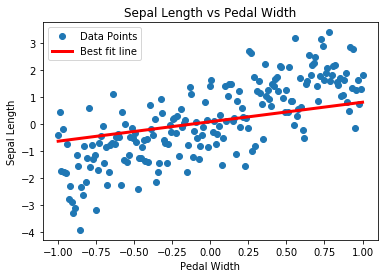

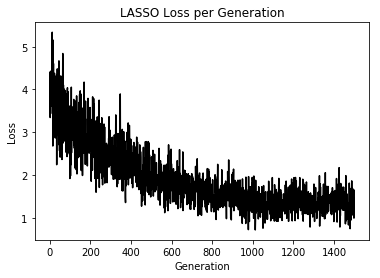

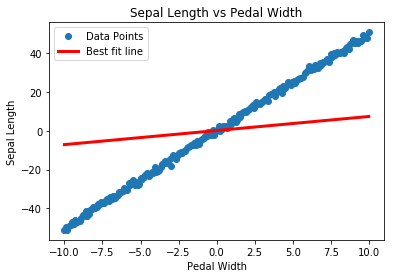

ValueError: operands could not be broadcast together with shapes (150,) (200,) 

In [65]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Parameters
learning_rate = 0.01
training_epochs = 1000
display_step = 50

# Generate the training data
train_X = np.linspace(-1, 1, 200)
train_Y = 2*train_X + np.random.randn(*train_X.shape)*0.2
random = [ - np.random.randn() for num in train_Y]
train_Y = train_Y - random

n_samples = train_X.shape[0]

_X = data.drop(jokes[75], axis=1)
_Y = data[jokes[75]]

n_dim = _X.shape[1]
rows = _X.shape[0]

# tf Graph Input
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Initialize the variable w and b
W = tf.Variable(np.random.randn(), name="weight")
b = tf.Variable(np.random.randn(), name="bias")

# Define the linear model
pred = tf.add(tf.multiply(X, W), b)

# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples)
cost = tf.add(cost, tf.multiply(1e-6, tf.global_norm([W])))
 
# LASSO and Ridge Regression
# 
# This function shows how to use TensorFlow to solve LASSO or 
# Ridge regression for 
# y = Ax + b
# 
# We will use the iris data, specifically: 
#   y = Sepal Length 
#   x = Petal Width

# import required libraries
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops


# Specify 'Ridge' or 'LASSO'
#regression_type = 'LASSO'
regression_type = 'LASSO'

# clear out old graph
ops.reset_default_graph()

# Create graph
sess = tf.Session()

###
# Load iris data
###

# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([x[3] for x in iris.data])
y_vals = np.array([y[0] for y in iris.data])

###
# Model Parameters
###

# Declare batch size
batch_size = 50

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# make results reproducible
seed = 13
np.random.seed(seed)
tf.set_random_seed(seed)

# Create variables for linear regression
A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare model operations
model_output = tf.add(tf.matmul(x_data, A), b)

###
# Loss Functions
###

# Select appropriate loss function based on regression type

if regression_type == 'LASSO':
    # Declare Lasso loss function
    # Lasso Loss = L2_Loss + heavyside_step,
    # Where heavyside_step ~ 0 if A < constant, otherwise ~ 99
    lasso_param = tf.constant(0.9)
    heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-50., tf.subtract(A, lasso_param)))))
    regularization_param = tf.multiply(heavyside_step, 99.)
    loss = tf.add(tf.reduce_mean(tf.square(y_target - model_output)), regularization_param)

elif regression_type == 'Ridge':
    # Declare the Ridge loss function
    # Ridge loss = L2_loss + L2 norm of slope
    ridge_param = tf.constant(1.)
    ridge_loss = tf.reduce_mean(tf.square(A))
    loss = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output)), tf.multiply(ridge_param, ridge_loss)), 0)
    
else:
    print('Invalid regression_type parameter value',file=sys.stderr)


###
# Optimizer
###

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

###
# Run regression
###

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Training loop
loss_vec = []
slopes = []
for i in range(1500):
    rand_index = np.random.choice(len(train_X), size=50)
    rand_x = np.transpose([train_X[rand_index]])
    rand_y = np.transpose([train_Y[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    slopes.append(sess.run(A))
    loss_vec.append(temp_loss[0])
    if (i+1)%300==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)) + ' b = ' + str(sess.run(b)))
        print('Loss = ' + str(temp_loss))
        print('\n')

###
# Extract regression results
###

# Get the optimal coefficients
[slope] = sess.run(A)
[y_intercept] = sess.run(b)

# Get best fit line
best_fit = []
for i in train_X:
  best_fit.append(float(slope*i+y_intercept))

print(((train_Y - best_fit)**2).mean(),1-((train_Y - best_fit)**2).sum() / ((best_fit - np.mean(best_fit))**2).sum())
###
# Plot results
###

# Plot regression line against data points
plt.plot(train_X, train_Y, 'o', label='Data Points')
plt.plot(train_X, best_fit, 'r-', label='Best fit line', linewidth=3)
plt.legend(loc='upper left')
plt.title('Sepal Length vs Pedal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title(regression_type + ' Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

train_X = np.linspace(-10, 10, 200)
train_Y = 5*train_X + np.random.randn(*train_X.shape)*0.2
random = [ - np.random.randn() for num in train_Y]
train_Y = train_Y - random
predict = []
for i in train_X:
  predict.append(float(slope*i+y_intercept))

# Plot regression line against data points
plt.plot(train_X, train_Y, 'o', label='Data Points')
plt.plot(train_X, predict, 'r-', label='Best fit line', linewidth=3)
plt.legend(loc='upper left')
plt.title('Sepal Length vs Pedal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')
plt.show()

print(((y_vals - best_fit)**2).mean(),1-((y_vals - best_fit)**2).sum() / ((best_fit - np.mean(best_fit))**2).sum())

print(((train_Y - predict)**2).mean(),1-((train_Y - predict)**2).sum() / ((predict - np.mean(predict))**2).sum())

Step #300 A = [[ 0.52371073]] b = [[-0.47357213]]
Loss = [[ 0.80011052]]


Step #600 A = [[ 0.51271355]] b = [[-0.43511879]]
Loss = [[ 0.84611142]]


Step #900 A = [[ 0.50306952]] b = [[-0.39718199]]
Loss = [[ 0.76114655]]


Step #1200 A = [[ 0.49052536]] b = [[-0.35970992]]
Loss = [[ 0.81446284]]


Step #1500 A = [[ 0.48233184]] b = [[-0.32266155]]
Loss = [[ 0.62602568]]




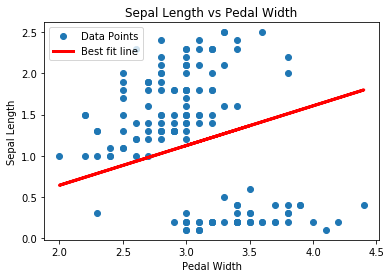

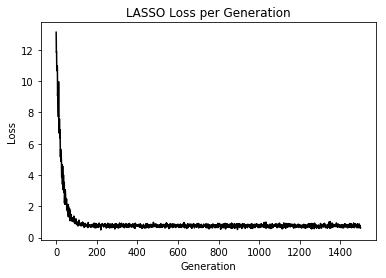

In [67]:
# LASSO and Ridge Regression
# 
# This function shows how to use TensorFlow to solve LASSO or 
# Ridge regression for 
# y = Ax + b
# 
# We will use the iris data, specifically: 
#   y = Sepal Length 
#   x = Petal Width

# import required libraries
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops


# Specify 'Ridge' or 'LASSO'
#regression_type = 'LASSO'
regression_type = 'LASSO'

# clear out old graph
ops.reset_default_graph()

# Create graph
sess = tf.Session()

###
# Load iris data
###

# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([x[1] for x in iris.data])
y_vals = np.array([y[3] for y in iris.data])

###
# Model Parameters
###

# Declare batch size
batch_size = 50

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# make results reproducible
seed = 13
np.random.seed(seed)
tf.set_random_seed(seed)

# Create variables for linear regression
A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare model operations
model_output = tf.add(tf.matmul(x_data, A), b)

###
# Loss Functions
###

# Select appropriate loss function based on regression type

if regression_type == 'LASSO':
    # Declare Lasso loss function
    # Lasso Loss = L2_Loss + heavyside_step,
    # Where heavyside_step ~ 0 if A < constant, otherwise ~ 99
    lasso_param = tf.constant(0.9)
    heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-50., tf.subtract(A, lasso_param)))))
    regularization_param = tf.multiply(heavyside_step, 99.)
    loss = tf.add(tf.reduce_mean(tf.square(y_target - model_output)), regularization_param)

elif regression_type == 'Ridge':
    # Declare the Ridge loss function
    # Ridge loss = L2_loss + L2 norm of slope
    ridge_param = tf.constant(1.)
    ridge_loss = tf.reduce_mean(tf.square(A))
    loss = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output)), tf.multiply(ridge_param, ridge_loss)), 0)
    
else:
    print('Invalid regression_type parameter value',file=sys.stderr)


###
# Optimizer
###

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

###
# Run regression
###

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Training loop
loss_vec = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = np.transpose([x_vals[rand_index]])
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss[0])
    if (i+1)%300==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)) + ' b = ' + str(sess.run(b)))
        print('Loss = ' + str(temp_loss))
        print('\n')

###
# Extract regression results
###

# Get the optimal coefficients
[slope] = sess.run(A)
[y_intercept] = sess.run(b)

# Get best fit line
best_fit = []
for i in x_vals:
  best_fit.append(slope*i+y_intercept)


###
# Plot results
###

# Plot regression line against data points
plt.plot(x_vals, y_vals, 'o', label='Data Points')
plt.plot(x_vals, best_fit, 'r-', label='Best fit line', linewidth=3)
plt.legend(loc='upper left')
plt.title('Sepal Length vs Pedal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title(regression_type + ' Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()